<a href="https://colab.research.google.com/github/Ericsmrk/csci-167/blob/main/intel_image_classification_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction


After investigating suitable datasets to learn more about using a convolutional neural network (CNN) for image classification, I came across the Intel Image Classification Dataset. Found on Kaggle [here](https://www.kaggle.com/datasets/puneet6060/intel-image-classification), the dataset consists of around 25 thousand images of size 150 by 150 depicting "Natural Scenes" from around the world that are classified under six categories: buildings, forests, glaciers, mountains, sea, and streets. This dataset is considered a real-world dataset that is simple but diverse enough for the scope of this class. This makes it a good choice for an introduction to CNN model creation. CNNs are widely known for highly effective feature extraction involved with image classification.

##Import Libraries

In [14]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Flatten, Dropout, MaxPooling2D, Dense, Input
from tensorflow.keras.optimizers import Adam, SGD, RMSprop # Import the Adam optimizer and others
from tensorflow.keras.callbacks import EarlyStopping

#Dataset Exploration

## Upload IIC Dataset

One of the first steps is to turn on the GPU.
Here are the instructions.

To enable the GPU, you need to change the runtime type:

Go to the 'Runtime' menu in your Colab notebook.
Select 'Change runtime type'.
In the 'Hardware accelerator' dropdown menu, select 'GPU'.
Click 'Save'.

In [4]:
# Check if TensorFlow is using GPU
if tf.test.gpu_device_name():
  print("GPU is enabled and available")
else:
  print("GPU is not enabled or available")


GPU is enabled and available


First we need to upload the dataset into the colab environment, the best way to do this is to mount the google drive and then unzip the dataset zip file from there.

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!unzip -q /content/drive/MyDrive/167/project/Intel_IC_Dataset.zip -d ./data
print("Dataset extracted to './data'!")


replace ./data/seg_pred/seg_pred/10004.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Dataset extracted to './data'!


##Dataset Analysis

Now that we have been able to upload the dataset to our Colab Python environment. We can start to analyze the dataset. First, I will go over summarizations of the features, data types, and categories present in the dataset. Second, I will provide a description of the proprocessing steps required before jumping into model creation.

###Dataset Description

As you can see in the following cell, the dataset has a total of SIX categories of images: buildings, forest, glacier, mountain, sea, and street. We display the total number of images per category in both training and testing datasets followed by a bar graph for the datasets detailing the distributions.

In [2]:
#Define paths
train_dir = './data/seg_train/seg_train'
test_dir = './data/seg_test/seg_test'
pred_dir = './data/seg_pred/seg_pred'

#List categories
categories = os.listdir(train_dir)

print("Dataset Overview:")
print(f"- Number of categories: {len(categories)}")
print(f"- Categories: {categories}")

#Count the number of images in each category
print("\nImage Counts per Category (Training Set):")
for category in categories:
    category_path = os.path.join(train_dir, category)
    print(f"{category}: {len(os.listdir(category_path))} images")

print("\nImage Counts per Category (Testing Set):")
for category in categories:
    category_path = os.path.join(test_dir, category)
    print(f"{category}: {len(os.listdir(category_path))} images")


Dataset Overview:
- Number of categories: 6
- Categories: ['street', 'forest', 'glacier', 'buildings', 'sea', 'mountain']

Image Counts per Category (Training Set):
street: 2382 images
forest: 2271 images
glacier: 2404 images
buildings: 2191 images
sea: 2274 images
mountain: 2512 images

Image Counts per Category (Testing Set):
street: 501 images
forest: 474 images
glacier: 553 images
buildings: 437 images
sea: 510 images
mountain: 525 images


###Distributions

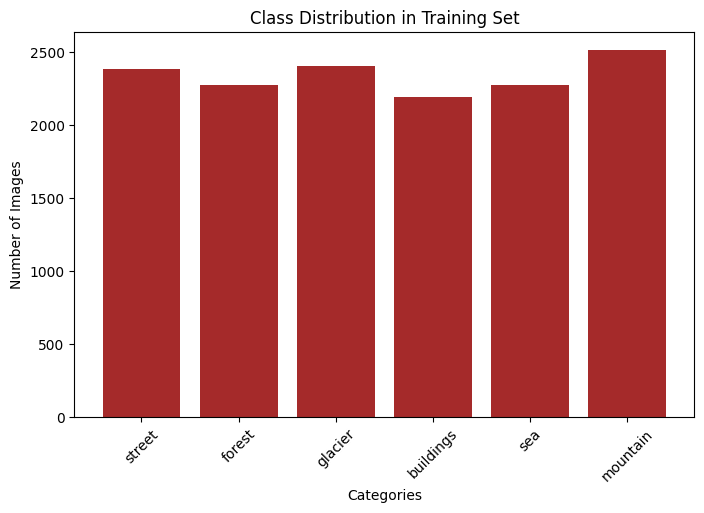

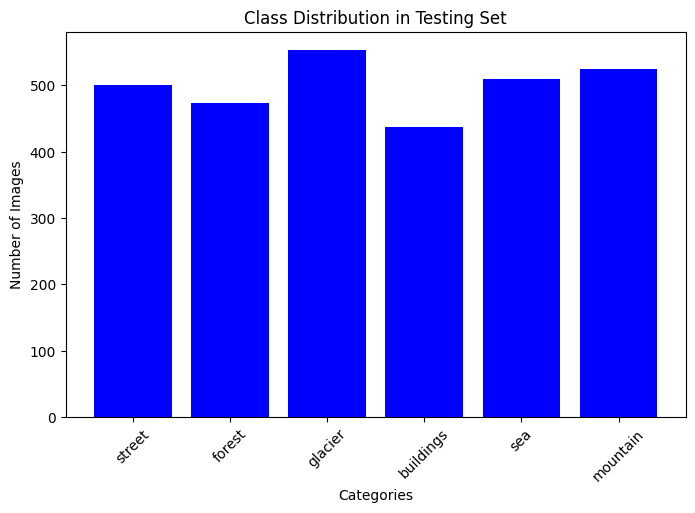

In [4]:
#Count images in each category for training set
category_counts = {category: len(os.listdir(os.path.join(train_dir, category))) for category in categories}

#Plot distribution
plt.figure(figsize=(8, 5))
plt.bar(category_counts.keys(), category_counts.values(), color='brown')
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Training Set')
plt.xticks(rotation=45)
plt.show()

#add a gap
print(" ")

#Count images in each category for testing set
category_counts = {category: len(os.listdir(os.path.join(test_dir, category))) for category in categories}

#Plot distribution
plt.figure(figsize=(8, 5))
plt.bar(category_counts.keys(), category_counts.values(), color='blue')
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Testing Set')
plt.xticks(rotation=45)
plt.show()

###Data Types
The next block of code shows that the shape of each image is 150 width by 150 height by 3 RGB channels.
The data type of the image array is a uint8.


In [5]:
#Check data type of one image
sample_path = os.path.join(train_dir, categories[0], os.listdir(os.path.join(train_dir, categories[0]))[0])
with Image.open(sample_path) as img:
    img_array = np.array(img)
    print(f"Sample Image Shape: {img_array.shape}")
    print(f"Data Type: {img_array.dtype}")

Sample Image Shape: (150, 150, 3)
Data Type: uint8


###Example Images
Next, lets look at some examples of the images that are included in this dataset. First I will show some examples of the TRAINING IMAGES, followed by examples of the TESTING IMAGES.

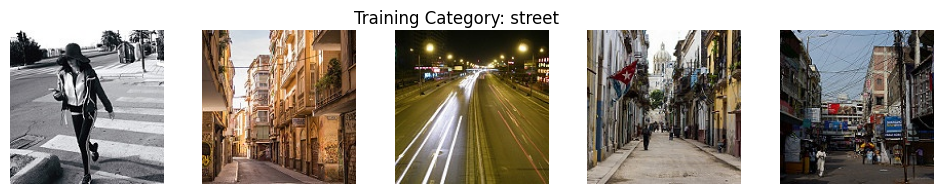

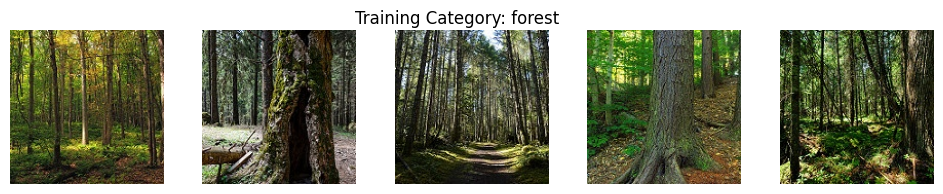

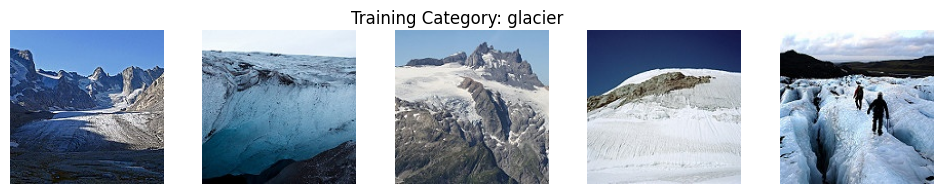

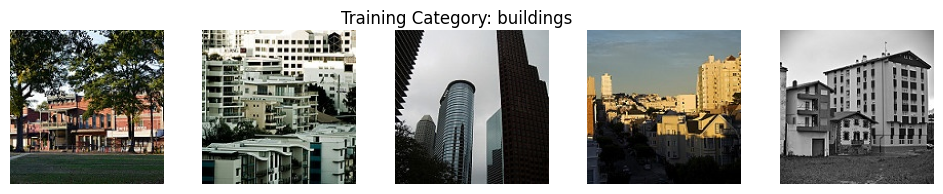

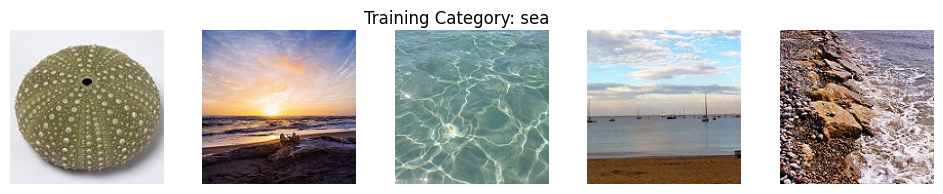

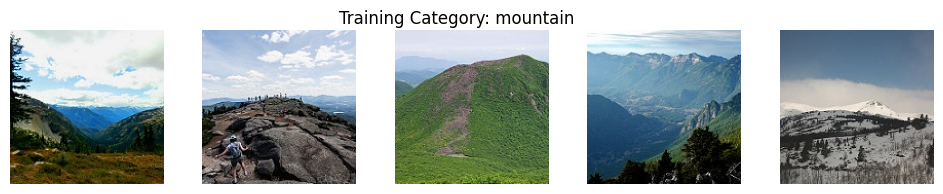

In [6]:
#Display a five random images from each category of the training dataset
for category in categories:
    category_path = os.path.join(train_dir, category)
    image_files = os.listdir(category_path)
    selected_images = random.sample(image_files, 5)

    fig, axes = plt.subplots(1, 5, figsize=(12, 2))
    fig.suptitle(f"Training Category: {category}")

    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(category_path, image_file)
        image = mpimg.imread(image_path)
        axes[i].imshow(image)
        axes[i].axis('off')

    plt.show()

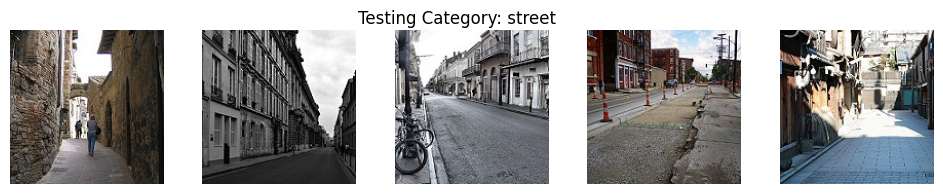

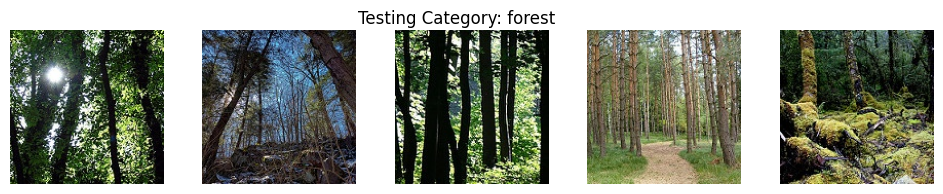

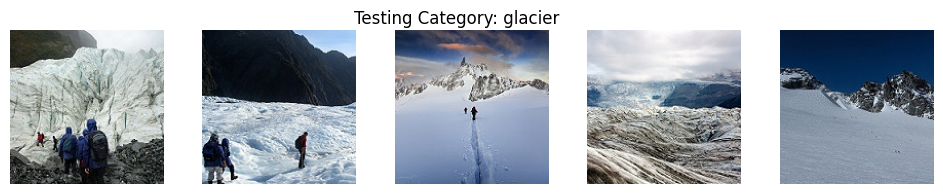

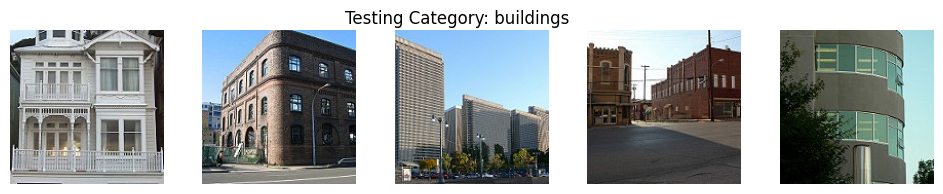

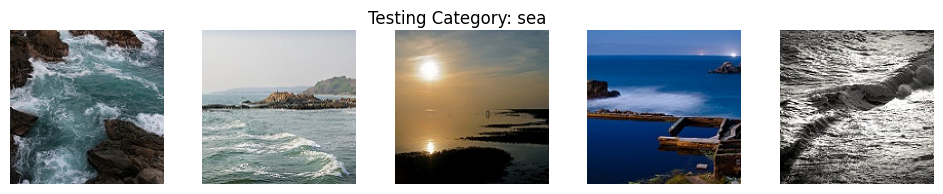

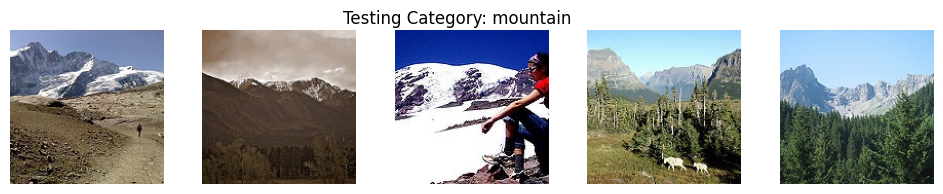

In [7]:
#Display a five random images from each category of the testing dataset
for category in categories:
    category_path = os.path.join(test_dir, category)
    image_files = os.listdir(category_path)
    selected_images = random.sample(image_files, 5)

    fig, axes = plt.subplots(1, 5, figsize=(12, 2))
    fig.suptitle(f"Testing Category: {category}")

    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(category_path, image_file)
        image = mpimg.imread(image_path)
        axes[i].imshow(image)
        axes[i].axis('off')

    plt.show()

##Preprocessing Steps

###Image and Batch Sizes
First, we will set the size of each image to 228 by 228, allowing for the preservation of the image details while allowing the data to be manageable for the GPU to handle. This allows for a good balance between balance and efficiency. I also set the batch size to 32, a common and widely used value for image classification tasks.

In [8]:
#set image and batch sizes
IMAGE_SIZE = (228, 228)
BATCH_SIZE = 32

###Create TensorFlow Datasets
The next chunk of code creates TensorFlow datasets for training and testing by automatically loading images from the specified directories, resizing them, batching them into manageable groups, and labeling them appropriately. This preparation ensures the data is ready for direct use in a TensorFlow training pipeline. Next, I extract full file paths for the training, testing, and prediction datasets, enabling manual inspection.



In [9]:
#Create TensorFlow datasets containing batches of
#preprocessed image data and labels for the train and the test
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)

#Get the class names
classes_names=train_ds.class_names
print(classes_names)

#Traverse the director to get the
#full file paths of all images and appends them to a list
def getImagePaths(path):
    image_names=[]
    for dirname, _,filenames in os.walk(path):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
    return image_names

#Retrieves all file paths in the pred_dir directory
images_paths_pred = getImagePaths(pred_dir)
pred_path_lens = len(images_paths_pred)
print("Predicted Array Sample: ", images_paths_pred[:2])#only first 2 examples
print("Predicted Array Length: ", pred_path_lens)

#Retrieves all file paths in the train_dir directory
images_paths_train = getImagePaths(train_dir)
train_path_lens = len(images_paths_train)
print("Training Array Sample: ", images_paths_train[:2])#only first 2 examples
print("Training Array Length: ", train_path_lens)

#Retrieves all file paths in the test_dir directory
images_paths_test = getImagePaths(test_dir)
test_path_lens = len(images_paths_test)
print("Testing Array Sample: ", images_paths_train[:2])#only first 2 examples
print("Testing Array Length: ", test_path_lens)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Predicted Array Sample:  ['./data/seg_pred/seg_pred/8828.jpg', './data/seg_pred/seg_pred/11501.jpg']
Predicted Array Length:  7301
Training Array Sample:  ['./data/seg_train/seg_train/street/14355.jpg', './data/seg_train/seg_train/street/2157.jpg']
Training Array Length:  14034
Testing Array Sample:  ['./data/seg_train/seg_train/street/14355.jpg', './data/seg_train/seg_train/street/2157.jpg']
Testing Array Length:  3000


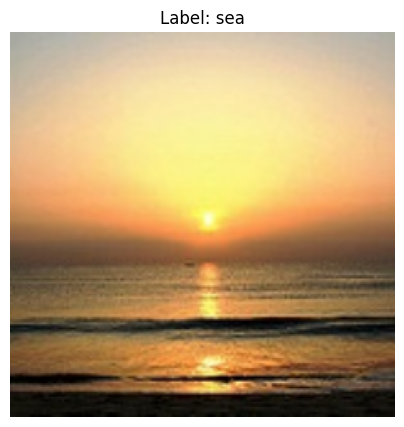

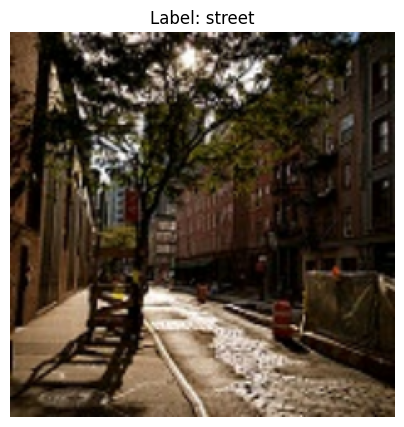

In [10]:
#Function to display a batch of images and their labels note: doesn't work after normalization occurs
def inspect_images(dataset, class_names, num_images=2):
    for images, labels in dataset.take(1):  #Take a single batch
        for i in range(num_images):
            plt.figure(figsize=(5, 5))
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f"Label: {class_names[labels[i]]}")
            plt.axis("off")
            plt.show()

#Inspect a couple of images from the training dataset
inspect_images(train_ds, classes_names)

###Autotune, Normalize, and Prefetch
Next we add a normalization layer to the preprocessed data images only, leaving the labels alone. This scales the images consistantly to improve the models convergance during training. I use the map function to apply the normalization dynamically without duplicating the dataset. Also, I enable parellel processing and prefetching to make the data load faster and reduce idle time.

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

Norm_layer = tf.keras.layers.Rescaling(1/255)
train_ds = train_ds.map(lambda x, y: (Norm_layer(x), y), num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (Norm_layer(x), y), num_parallel_calls=AUTOTUNE)

#Prefetch data to improve performance
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

#Model Creation

Next, we enter the Model Creation phase of the project, where I will create a custom CNN to analyze the images within the training dataset so we can make some predictions about the images in the testing dataset. While there are already pre-trained models that might have a higher accuracy, I chose this route because I want to be in control of this model to learn how to improve it. Another reason is that this dataset is of moderate size. Firstly, I will create a simple, lightweight model that works well for the task at hand, and then, in the Hyperparameter Exploration section, I will add more complexity.

##Keras Imports
```
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
```
In the "Import Libraries" Section, I run the above code to import key functionality from the module Keras, which is integrated into TensorFlow 2.0. In this case, TensorFlow acts as the main computational framework and Keras is the high-level application programming interface that builds the actual model. The code below imports a class "Sequential," allowing me to create the network layer by layer.
```
from tensorflow.keras.models import Sequential
```
The code below imports various layers, I will describe them in detail.
```
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
```
Conv2D is a layer that is responsible for performing two-dimensional convolution operations. This allows the model to extract spatial features such as edges and other patterns from the input images and create a 2D feature map (filter) for the extraction. You can specify some hyperparameters, such as the number of filters, kernel size, and the activation function here.

The MaxPooling2D layer downsamples (reduces) the input image's height and width (spatial dimensions) while preserving the essential features of the image. Here we can set a hyperparameter to define the wanted pool size and the stride.

The Flatten layer takes the 2D feature map returned from the Conv2D layer and converts it into a 1D feature vector.

The Dense layer is a fully connected layer where each neuron receives input from all neurons in the previous layer. Here, we can assign the hyperparameters for the number of neurons in the layer and an activation function.

Finally, we can use the Dropout layer to randomly set some of the neurons to zero, effectively deactivating them. This can help the network learn better and prevent overfitting. The hyperparameter here is the drop rate.


## Define Layers
Next I define code for the model, version one. Every line is commented to provide a description.

In [12]:
#Create a model sequentially
model = Sequential([

    #Input layer defining the input shape
    #input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),

    #HiddenLayer 1
    Conv2D(32, (3, 3), #32 filters, 3x3 kernel size
           activation='relu', #apply relu activation
           input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)), #input layer defining the input shape

    #HiddenLayer 2
    MaxPooling2D(pool_size=(2, 2), #downsample by factor 2 for width and height
                 strides=(2, 2)), #stride is set to default

    #HiddenLayer 4
    Conv2D(64, (3, 3), #64 filters, 3x3 kernel size
           activation='relu'), #apply relu activation

    #HiddenLayer 5
    MaxPooling2D(pool_size=(2, 2), #downsample by factor 2 for width and height
                 strides=(2, 2)), #stride is set to default

    #HiddenLayer 6
    Conv2D(128, (3, 3), #128 filters, 3x3 kernel size
           activation='relu'), #apply relu activation

    #HiddenLayer 7
    MaxPooling2D(pool_size=(2, 2), #downsample by factor 2 for width and height
                 strides=(2, 2)), #stride is set to default

    #HiddenLayer 8
    Flatten(), #Converts the 2D feature maps into a 1D vector, connects the dense layers

    #Fully connected layers
    #HiddenLayer 9
    Dense(128, activation='relu'), #128 neurons and ReLU activation

    #HiddenLayer 10
    Dropout(0.5),  #Dropout to reduce overfitting, deactives 50% of neurons

    #Output layer for multi-class classification
    Dense(len(classes_names), #number of neurons equals the number of classes
          activation='softmax') #converts the output of layer into a probability distribution over multiple classes
])

# Model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 226, 226, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 113, 113, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 111, 111, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 55, 55, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 53, 53, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,734 (42.61 MB)

 Trainable params: 11,169,734 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

##Training
Before we jump into the training, we have a few more hyperparameters to set.


###Model Compilation
Here, I configure the compilation of the CNN by choosing an optimizer, the loss function, and a performance indicator.

To adjust the model's weights during training, I have chosen to use Adaptive Moment Estimation (ADAM), which applies the default parameters that I describe in the code, allowing possible changes to occur later on quickly.

I chose Sparse Categorical Crossentropy for the loss function because it is a standard for multi-class classification where the labels are simple integers, as in our case. It was found to be unnecessary to try and alter different parameters with the loss.

For performance metrics, I am only using accuracy at the moment. I had trouble implementing other metrics, such as precision, recall, and AUC. My dataset may not work well with these other performance metrics.

In [18]:
#Explicitly define the optimizer with default parameters
optimizer = Adam(
    learning_rate=0.001,  #Default learning rate
    beta_1=0.9,          #Default exponential decay rate for the first moment estimates
    beta_2=0.999,        #Default exponential decay rate for the second moment estimates
    epsilon=1e-07,       #Small constant to prevent division by zero
    amsgrad=False        #Whether to apply the AMSGrad variant of Adam
)

model.compile(
    optimizer='adam',  #Adaptive optimizer
    loss='sparse_categorical_crossentropy',  #Use sparse since labels are integer-encoded
    metrics=[
        'accuracy'        #Accuracy metric
    ]
)


###Train the Model
Here we finally get to train our model with the datasets loaded, epochs set, we can view the initial results after.

In [19]:
#Train the model
history = model.fit(
    train_ds,                 #train_ds for the training
    validation_data=test_ds,  #test_ds for validation during training
    epochs=20,                 #Epochs is a hyperparameter to be exploited
    verbose=1                 #Show detailed progress during training
)


Epoch 1/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 40s 72ms/step - accuracy: 0.4619 - loss: 1.3814 - val_accuracy: 0.6367 - val_loss: 0.8995
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 25s 58ms/step - accuracy: 0.6675 - loss: 0.8873 - val_accuracy: 0.7357 - val_loss: 0.7038
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 41s 57ms/step - accuracy: 0.7468 - loss: 0.7102 - val_accuracy: 0.7860 - val_loss: 0.6030
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 44s 64ms/step - accuracy: 0.8058 - loss: 0.5582 - val_accuracy: 0.8010 - val_loss: 0.5964
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 42s 65ms/step - accuracy: 0.8391 - loss: 0.4553 - val_accuracy: 0.8157 - val_loss: 0.5958
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.8742 - loss: 0.3660 - val_accuracy: 0.8077 - val_loss: 0.6396
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 0.8910 - loss: 0.3092 - val_accuracy: 0.8213 - val_loss: 0.6874
Epoch 8/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 27s 61ms/step - accuracy: 0.9115 - loss: 0.2448 - 

###Baseline Results
Here I share the first set of baseline results to serve as a benchmark for comparing the outcomes of hyperparameter tuning, architecture adjustments, or additional techniques I add in later after hyperparameter exploration.

In [20]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8178 - loss: 1.2364
Test Loss: 1.2170
Test Accuracy: 0.8180


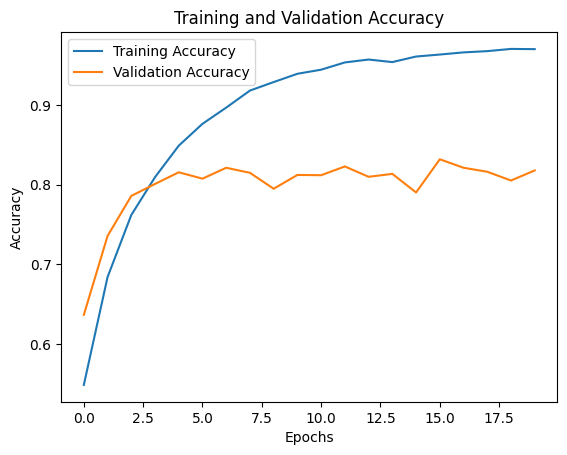

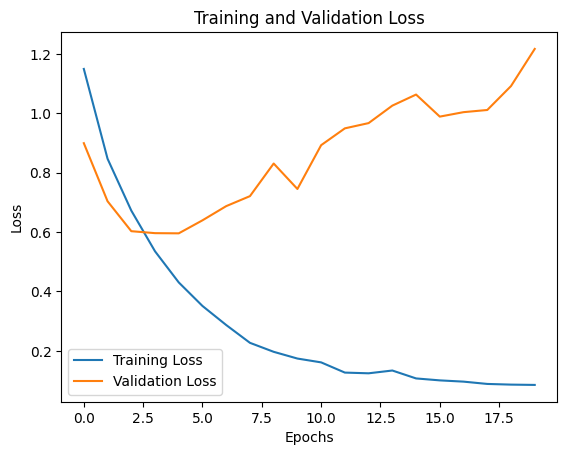

In [21]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


As you can see above, the training accuracy improved steadily and approached near-perfect levels, while the validation accuracy plateaued and fluctuated after about 5-7 epochs. Similarly, the training loss consistently decreased, but the validation loss began increasing after a few epochs. These trends indicate overfitting, as the model performed well on the training data but struggled to generalize to unseen validation data. I feel as if the results are great for a first run at this.

##Hyperparameter Exploration

Training with lr=0.001, optimizer=Adam, epochs=10
Epoch 1/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 30s 63ms/step - accuracy: 0.9811 - loss: 0.0653 - val_accuracy: 0.8100 - val_loss: 1.4409
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 40s 63ms/step - accuracy: 0.9821 - loss: 0.0641 - val_accuracy: 0.7753 - val_loss: 1.6813
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 26s 58ms/step - accuracy: 0.9710 - loss: 0.0862 - val_accuracy: 0.8200 - val_loss: 1.2623
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 27s 62ms/step - accuracy: 0.9804 - loss: 0.0681 - val_accuracy: 0.8063 - val_loss: 1.1833
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 24s 55ms/step - accuracy: 0.9861 - loss: 0.0461 - val_accuracy: 0.8117 - val_loss: 1.5737
Epoch 6/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 43s 60ms/step - accuracy: 0.9831 - loss: 0.0459 - val_accuracy: 0.8267 - val_loss: 1.6215
Epoch 7/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 24s 55ms/step - accuracy: 0.9819 - loss: 0.0576 - val_accuracy: 0.8240 - val_loss: 1.3133
Epoch 8/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 

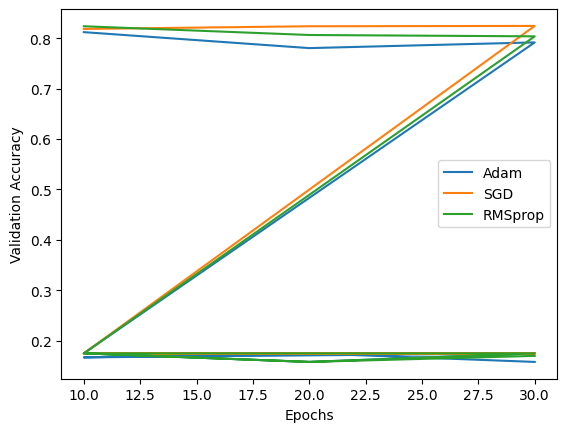

In [28]:
# Example hyperparameters
learning_rates = [0.001, 0.01, 0.1]
optimizers = [Adam, SGD, RMSprop]
epochs_list = [10, 20, 30]

# Results storage
results = []

# Experiment loop
for lr in learning_rates:
    for optimizer in optimizers:
        for epochs in epochs_list:
            print(f"Training with lr={lr}, optimizer={optimizer.__name__}, epochs={epochs}")
            model.compile(optimizer=optimizer(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

            #Train the model
            history = model.fit(
                train_ds,                 #train_ds for the training
                validation_data=test_ds,  #test_ds for validation during training
                epochs=epochs,                 #Epochs is a hyperparameter to be exploited
                verbose=1                 #Show detailed progress during training
)

            # Store results
            final_accuracy = history.history['val_accuracy'][-1]
            results.append({'learning_rate': lr, 'optimizer': optimizer.__name__, 'epochs': epochs, 'accuracy': final_accuracy})

# Convert results to DataFrame for better analysis
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)

# Plot to analyze
for opt in optimizers:
    opt_name = opt.__name__
    subset = results_df[results_df['optimizer'] == opt_name]
    plt.plot(subset['epochs'], subset['accuracy'], label=f"{opt_name}")

plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.show()
